In [21]:
import retro
import torch
import random
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch.nn.functional as F

import pyspark

spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

spark = (pyspark.sql.SparkSession
         .builder
         .master('local[8]')
         .appName('lecture')
         .getOrCreate())

sc = spark.sparkContext

mean  
max_  
difference  
frequency  
variance  
reverse tree eg autoenc  

In [22]:
actions = {
    'Left':      [0, 0, 0, 0, 0, 0, 1, 0, 0],
    'Right':     [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Jump':      [0, 0, 0, 0, 0, 0, 0, 0, 1],
    'None':      [0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Crouch':    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    # 'Dash':      [0, 0, 1, 0, 0, 0, 0, 0, 0],
    # 'RightDash': [0, 0, 1, 0, 0, 0, 0, 1, 0],
    'LeftJump':  [0, 0, 0, 0, 0, 0, 1, 0, 1],
    'RightJump': [0, 0, 0, 0, 0, 0, 0, 1, 1]
}

actions = list(actions.values())

---
### enchiridion

In [3]:
def blocks_identify(frame):
    obs = torch.tensor(frame)

    obs = torch.cat([obs,
                     torch.zeros(16, 240, 3)]).long()

    blocks = block_partition(obs, 16)

    # blocks = blocks[4*15:-2*15]

    asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3
    encodings_frame = [((block.flatten().float() @ asymmetric / 16 / 16 / 3 / 255)).item() for block in blocks]

    return encodings_frame

aa = torch.tensor(asymmetric).reshape(16, 16, 3).unsqueeze(0).permute(0, 3, 1, 2)
filter_ = torch.tensor(aa, dtype=torch.float)
filter_ = filter_ / 16 / 16 / 3 / 255

#aa = aa.detach().copy()
def blocks_identify2(frame):
    # encodings_frame = (frame.reshape(-1, 16*16*3) * asymmetric / 16 / 16 / 3 / 255).sum(axis=1)
    import torch.nn.functional as F

    t = torch.tensor(frame).unsqueeze(0).float()
    image = t.permute(0, 3, 1, 2)

    output = F.conv2d(input=image,
                      weight=filter_,
                      stride=16)

    return output.flatten()

print(len(blocks_identify(f)))
print(len(blocks_identify2(f)))

print(np.mean(blocks_identify(f)[:-15]))
print(np.mean(blocks_identify2(f).numpy()))

#14.4ms %timeit blocks_identify(f)
#1.66ms %timeit blocks_identify2(f)
#648us %timeit blocks_identify2(f)

plt.plot(blocks_identify(f))
plt.plot(blocks_identify2(f));

NameError: name 'asymmetric' is not defined

In [ ]:
import retro

def block_partition(matrix, block_width):
    matrix = matrix.reshape(-1, block_width, matrix.shape[0] // block_width, block_width, 3)
    matrix = matrix.transpose(2, 1).reshape(-1, block_width, block_width, 3)

    return matrix

class Environment2_0:
    def __init__(self):
        self.environment = retro.make(game='SuperMarioBros-Nes')

        self.blocks_seen = []
        self.blocks_seen_urls = []

        self.encodings = set()
        self.encodings_frame = set()
        
        self.asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3

        self.frame = self.environment.reset()
        self.blocks_identify(self.frame)

    def step(self, action, commitment_interval):
        for _ in range(commitment_interval):
            self.frame, reward, is_done, information = self.environment.step(action)
        
        self.blocks_identify(self.frame)

        return self.frame, reward, is_done, information

    def close(self):
        self.environment.render(close=True)
        self.environment.close()

    # __del__ = close

    def blocks_identify(self, frame):
        obs = torch.tensor(frame)

        obs = torch.cat([obs,
                         torch.zeros(16, 240, 3)]).long()

        blocks = block_partition(obs, 16)

        blocks = blocks[4*15:-2*15]
        
        # blocks = blocks.numpy()

        encodings_frame = [((block.flatten().float() @ self.asymmetric / 16 / 16 / 3 / 255)).item() for block in blocks]
        # print("ENCODINGS_FRAME", encodings_frame)
        self.encodings.update(encodings_frame)
        
    def blocks_identify_all(self):
        return self.encodings

    def interface_render(self):
        self.blocks_seen_urls = sorted(self.blocks_seen_urls)
        return self.frame.tolist(), list(self.encodings_frame), self.blocks_seen_urls


In [23]:
import retro

def block_partition(matrix, block_width):
    matrix = matrix.reshape(-1, block_width, matrix.shape[0] // block_width, block_width, 3)
    matrix = matrix.transpose(2, 1).reshape(-1, block_width, block_width, 3)

    return matrix

class Environment2:
    def __init__(self):
        self.environment = retro.make(game='SuperMarioBros-Nes')

        self.blocks_seen = []
        self.blocks_seen_urls = []
        
        self.frames_all = []

        self.encodings = set()
        self.encodings_frame = set()
        
        self.asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3

        self.frame = self.environment.reset()
        self.frames_all.append(self.frame)
        # self.blocks_identify(self.frame)

    def step(self, action, commitment_interval):
        for _ in range(commitment_interval):
            self.frame, reward, is_done, information = self.environment.step(action)
        
        # self.blocks_identify(self.frame)
        self.frames_all.append(self.frame)

        return self.frame, reward, is_done, information

    def close(self):
        self.environment.render(close=True)
        self.environment.close()

    # __del__ = close

    def blocks_identify_all(self):
        t = torch.tensor(np.stack(self.frames_all)).float()
        print(t.shape)
        images = t.permute(0, 3, 1, 2)

        asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3
        asymmetric = asymmetric.numpy()
        
        aa = torch.tensor(asymmetric).reshape(16, 16, 3).unsqueeze(0).permute(0, 3, 1, 2)
        filter_ = torch.tensor(aa, dtype=torch.float)
        filter_ = filter_ / 16 / 16 / 3 / 255

        output = F.conv2d(input=images,
                          weight=filter_,
                          stride=16)

        output = output[:, :, 4:-1]
        
        # print(output.shape)
        
        return output

    def interface_render(self):
        self.blocks_seen_urls = sorted(self.blocks_seen_urls)
        return self.frame.tolist(), list(self.encodings_frame), self.blocks_seen_urls


In [6]:
actions_1 = [actions[random.randint(0, len(actions)-1)] for _ in range(10000)]

In [16]:
actions_1=[]

In [100]:
400*24/6

1600.0

In [17]:
# %%time

import numpy as np
import random

def generate_play(step_count, actions_given):
    environment = Environment2_0()
    
    # for _ in range(step_count):
    frame = environment.frame
    for _, action in zip(range(step_count), actions_given):
        # action = actions[random.randint(0, len(actions)-1)]

        # for _ in range(6):
        frame, reward, is_done, information = environment.step(action, 6)

        if information['lives'] == 1:
            break
        
    environment.close()
    
    encodings = environment.blocks_identify_all()
            
    return encodings, frame


# %timeit (l, f) = generate_play(100, actions_given=actions_1)
(l1, f) = generate_play(1607, actions_given=actions_1)
print(len(l1))#, f)

plt.imshow(f)

NameError: name 'Environment2_0' is not defined

In [42]:
lO1 = [0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.3976414203643799, 0.3706384003162384, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.38585180044174194, 0.2375974804162979, 0.3879132568836212, 0.39773112535476685, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.6801009178161621, 0.5710622072219849, 0.5710622072219849, 0.6831099390983582, 0.45728638768196106, 0.45728638768196106, 0.4648599326610565, 0.45728638768196106, 0.5188837647438049, 0.5542463064193726, 0.5542463064193726, 0.5542463064193726, 0.5542463064193726, 0.5542463064193726, 0.5542463064193726, 0.5096045136451721, 0.5134382247924805, 0.5134382247924805, 0.5060616731643677]

In [46]:
len(lO1), len(l2.flatten().numpy())

(135, 135)

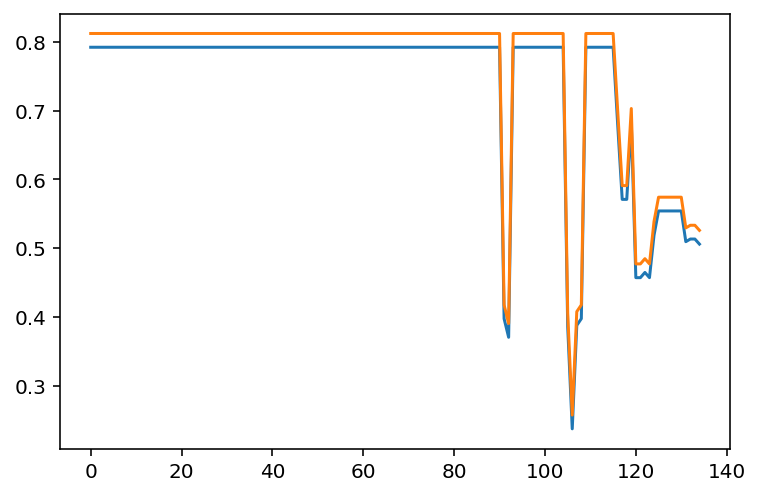

In [55]:
plt.plot(lO1)
plt.plot(0.02 + l2.flatten())

torch.Size([1608, 224, 240, 3])


<ipython-input-15-2515517e476e>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filter_ = torch.tensor(aa, dtype=torch.float)


4259


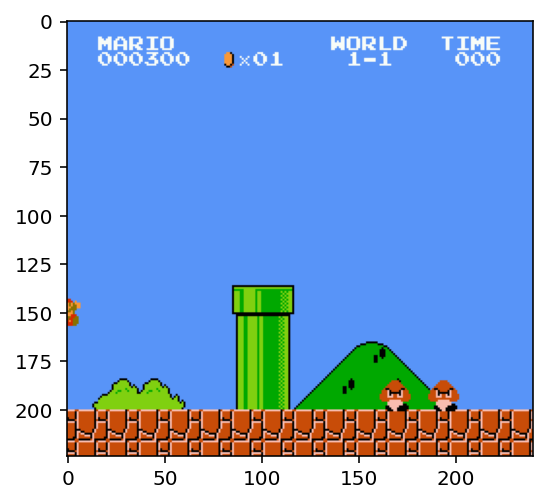

In [18]:
# %%time

import numpy as np
import random

def generate_play(step_count, actions_given=None):
    # environment = Environment2_0()
    environment = Environment2()
    
    frame = environment.frame
    # for _, action in zip(range(step_count), actions_given):
    for _ in range(step_count):
        action = actions[random.randint(0, len(actions)-1)]

        # for _ in range(6):
        frame, reward, is_done, information = environment.step(action, 6)

        if information['lives'] == 1:
            break
        
    environment.close()
    
    encodings = environment.blocks_identify_all()
            
    return len(encodings.unique()), frame


# %timeit (l, f) = generate_play(100, actions_given=actions_1)
(l2, f) = generate_play(1607, actions_given=actions_1)
# len(l), f
# print(len(l2.unique()))
print(l2)
plt.imshow(f)

In [12]:
l

0

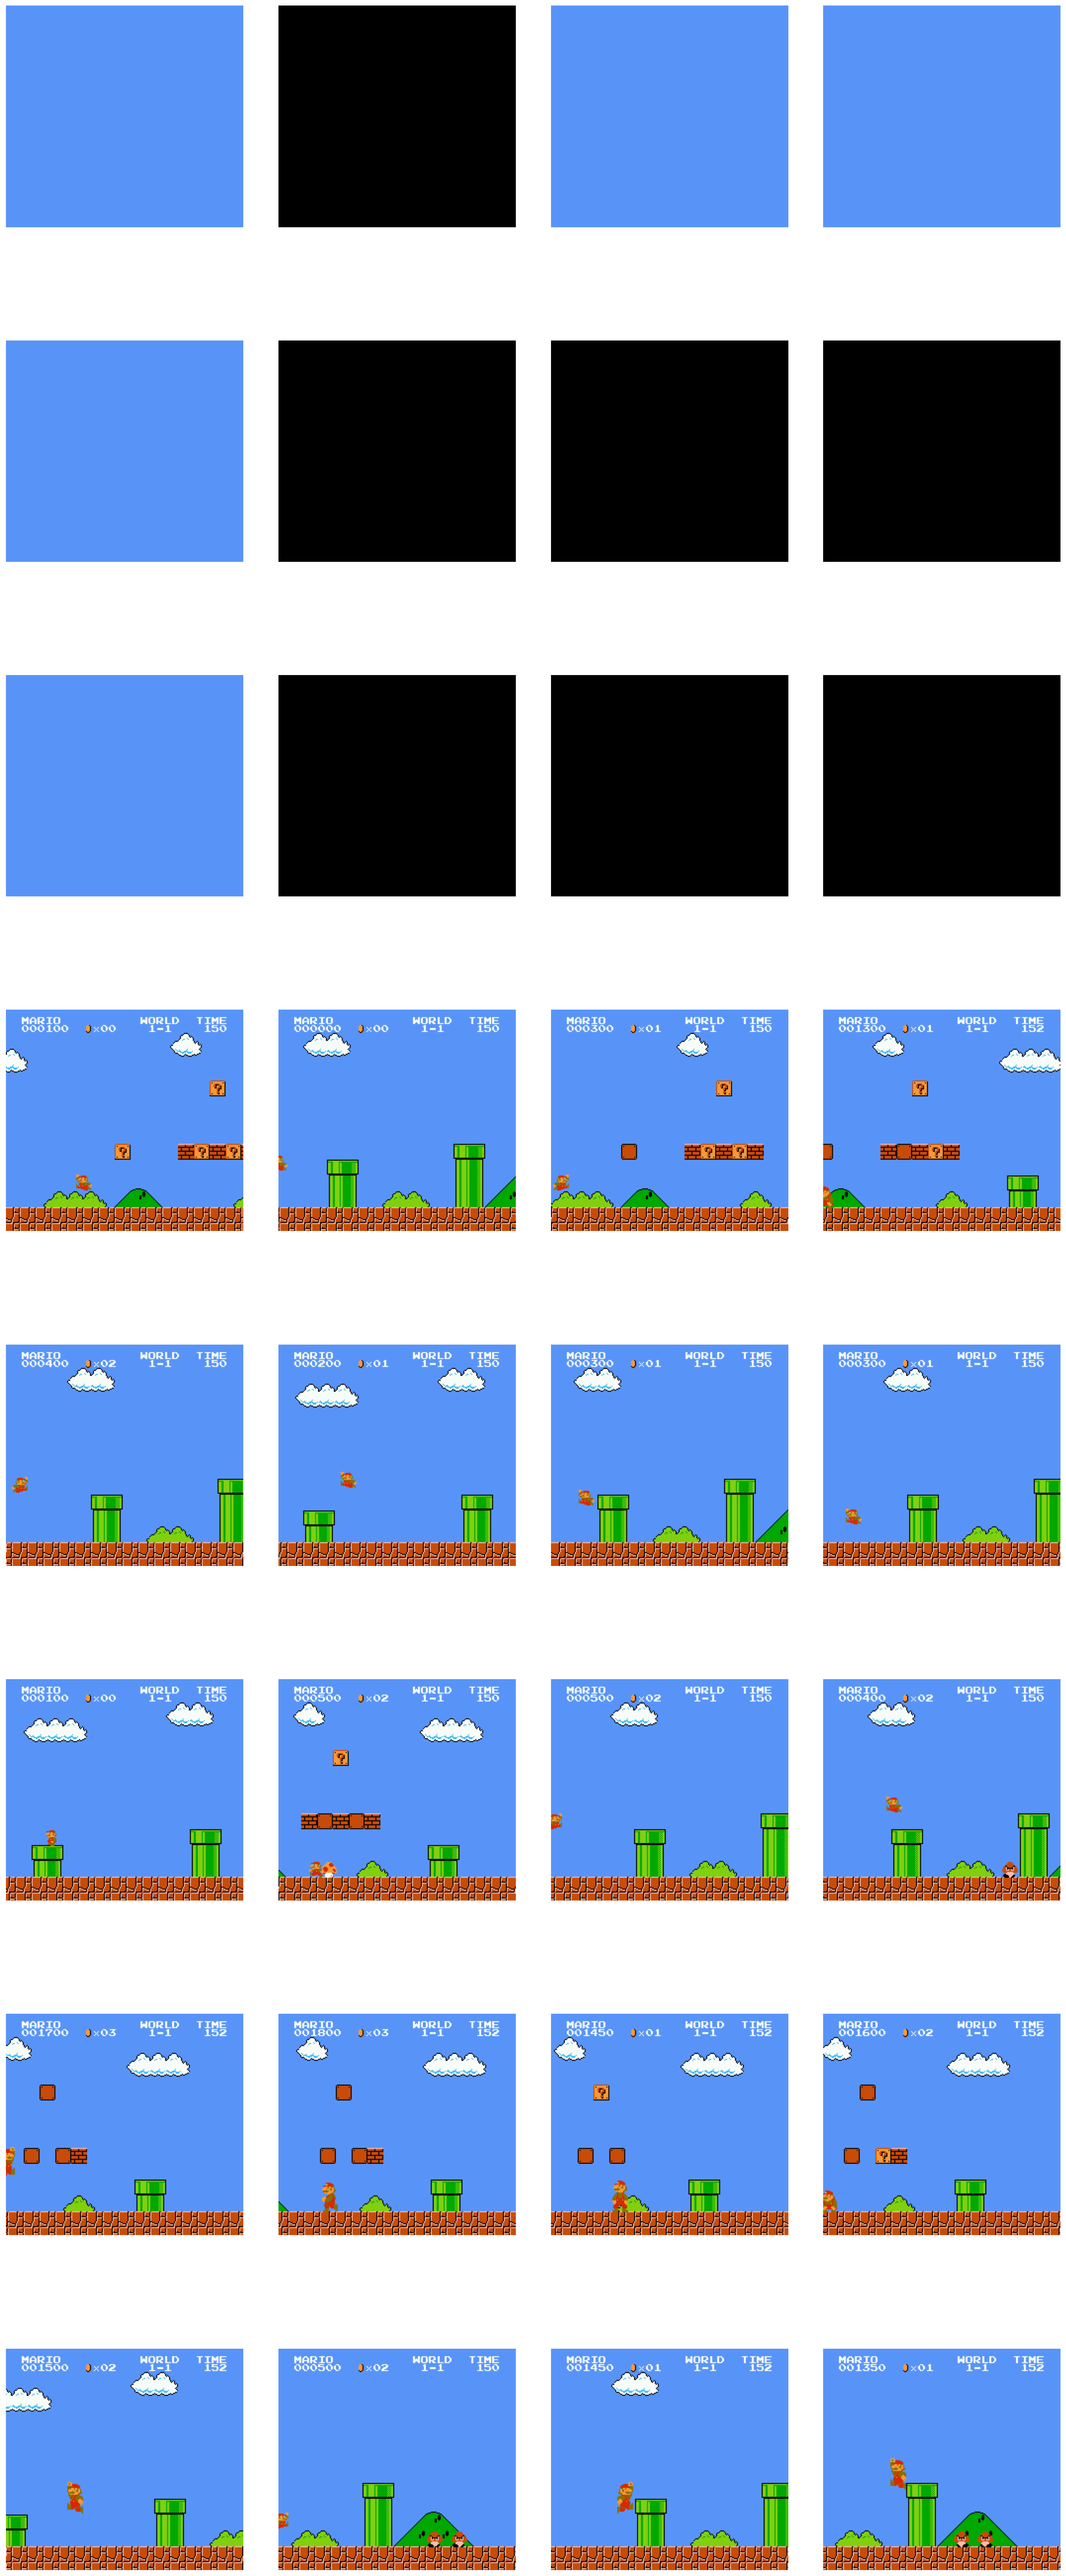

In [27]:

fig, axs = plt.subplots(8, 4, figsize=(18, 44))
axs = axs.flatten()
fig.tight_layout()

for ax, (l, frame) in zip(axs, frames):
    ax.imshow(frame)
    ax.axis('off')

In [25]:
frames = sorted(frames, key=lambda x: x[0])

In [24]:
frames = environments.collect()



TypeError: sorted expected 1 argument, got 2

torch.Size([1608, 224, 240, 3])


<ipython-input-59-37367ac2235c>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filter_ = torch.tensor(aa, dtype=torch.float)


torch.Size([1608, 1, 9, 15])
4987


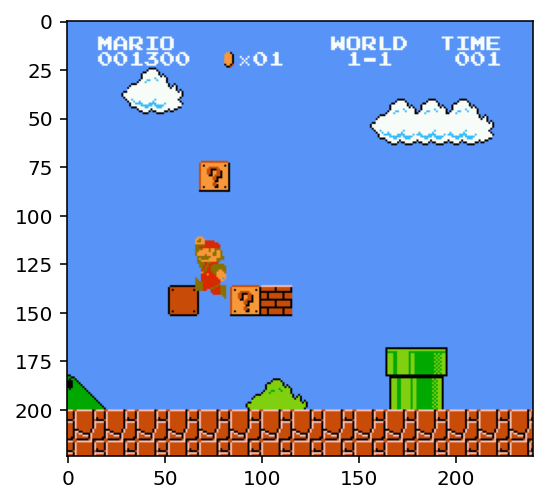

In [92]:
# %%time

import numpy as np
import random

def generate_play(step_count, actions_given=None):
    # environment = Environment2_0()
    environment = Environment2()
    
    frame = environment.frame
    # for _, action in zip(range(step_count), actions_given):
    for _ in range(step_count):
        action = actions[random.randint(0, len(actions)-1)]

        frame, reward, is_done, information = environment.step(action, 6)

        if information['lives'] == 1:
            break
        
    environment.close()
    
    encodings = environment.blocks_identify_all()
            
    return len(encodings.unique()), frame


# %timeit (l, f) = generate_play(100, actions_given=actions_1)
(l2, f) = generate_play(1607, actions_given=actions_1)
# len(l), f
# print(len(l2.unique()))
print(l2)
plt.imshow(f)

In [ ]:
32x100  sparksort noblocksaccumulate innerfloat 5min21s
32x100  sparksort noblocksaccumulate broadcast  3min27s
32x100  sparksort torch full convolve 18.5s
32x1000 sparksort torch full convolve 1min47s
32x800  sparksort torch full convolve 1min39s
64x800  sparksort torch full convolve 3min41s
128x800 sparksort torch full convolve 6min18s
128x800 c5 4xlarge local8    1min44s
128x800 c5 4xlarge local16   1min52s
1024x1000 c5 4xlarge local8 16min41s
512x1000 c5 4xlarge local8   8min14s
512x1000 c5 4xlarge local16  8min23s

In [ ]:
(150 + 8) x 512 x 1000

In [108]:
(150+8)*512*1000

80896000

CPU times: user 2.04 s, sys: 201 ms, total: 2.24 s
Wall time: 6min 18s


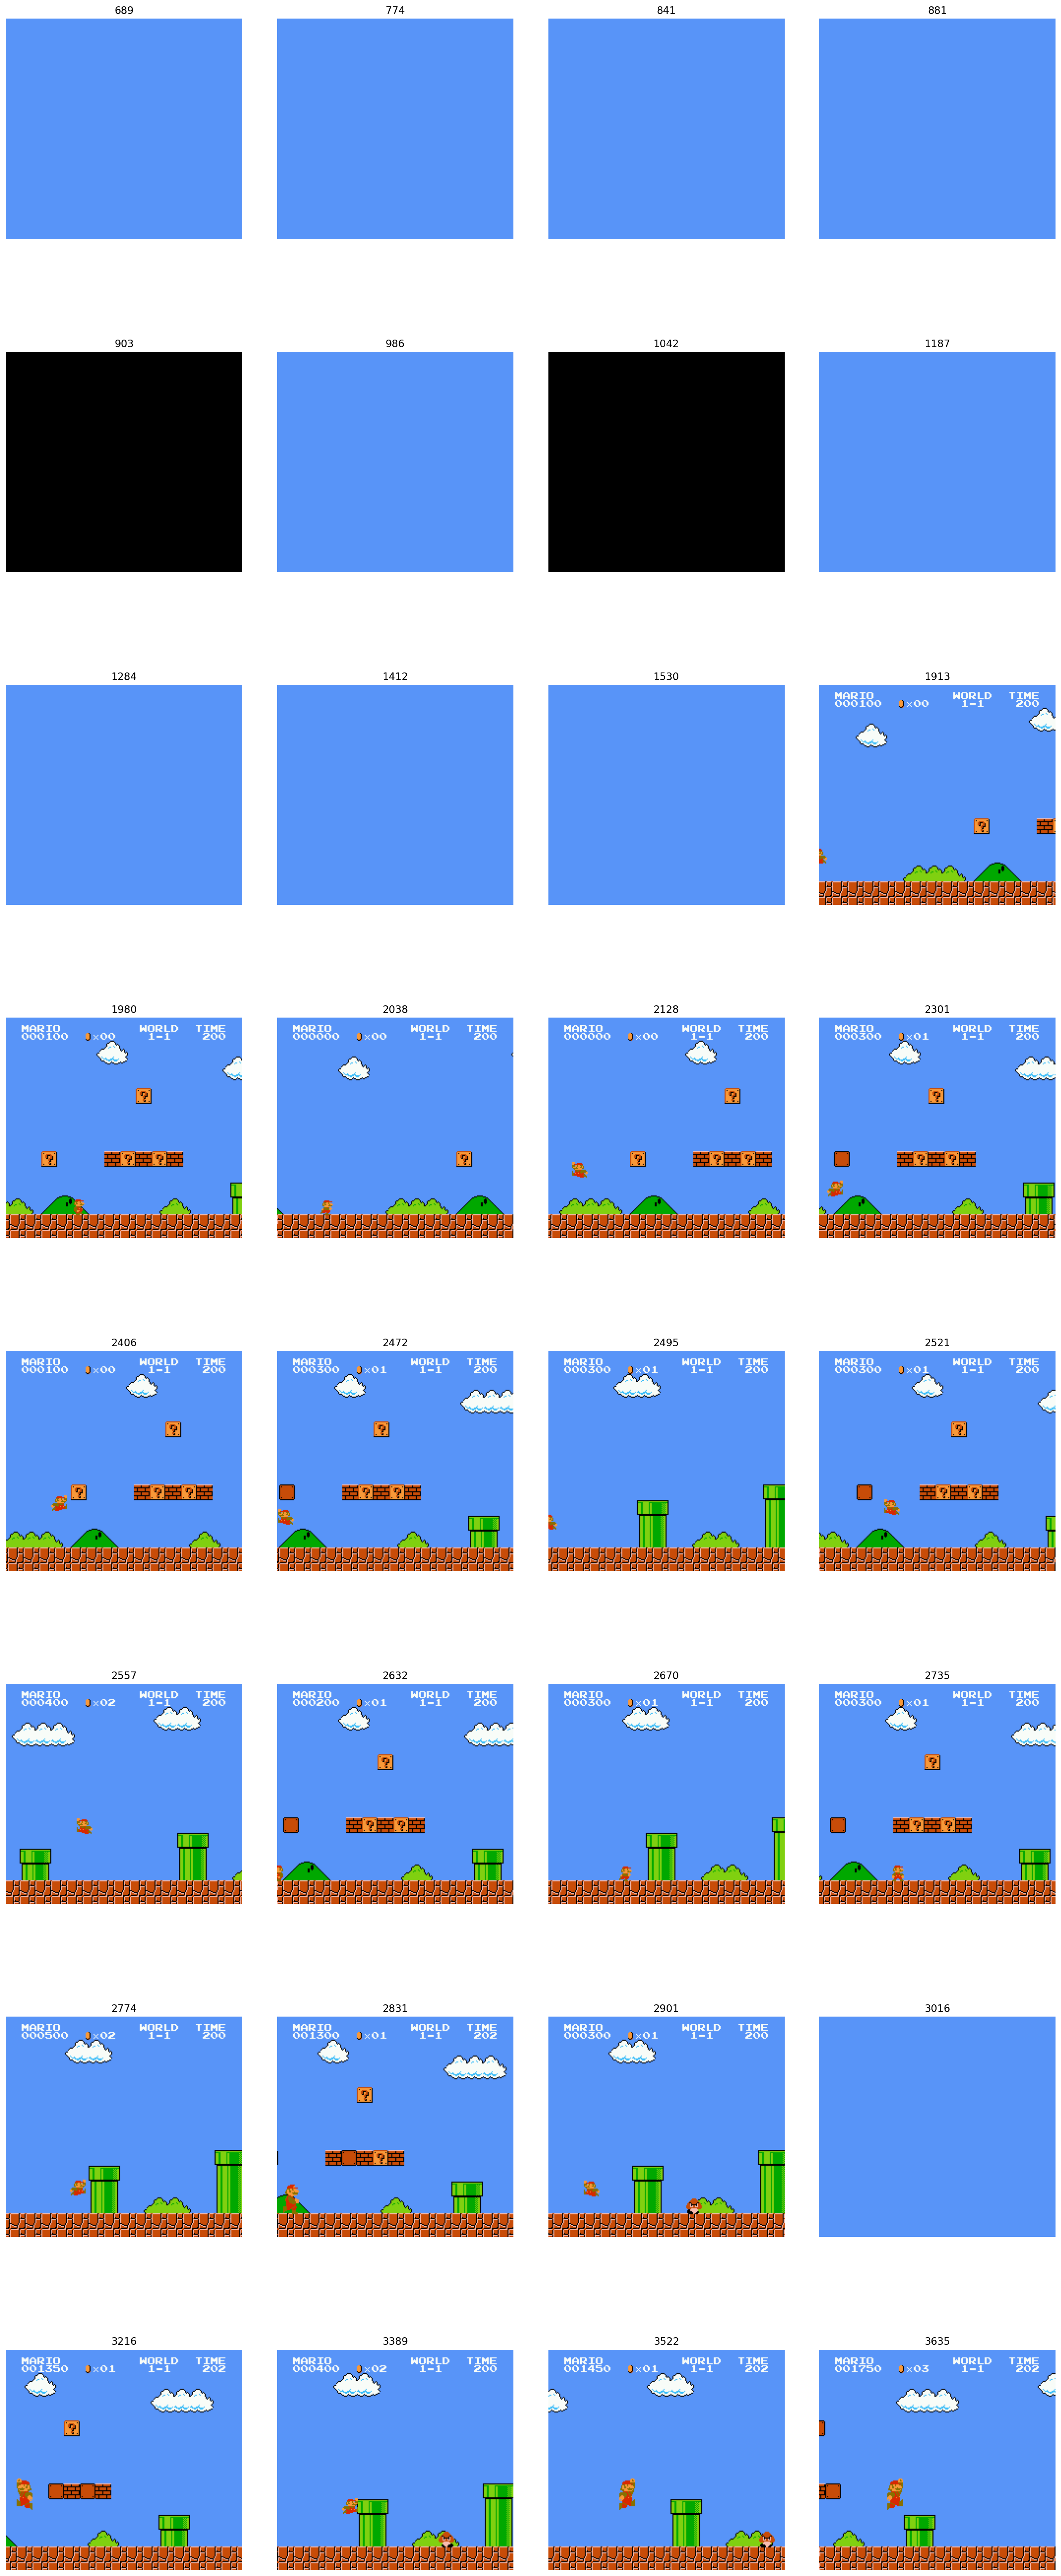

In [103]:
%%time

import matplotlib.pyplot as plt

environments = sc.parallelize(range(128)) .map (lambda x: generate_play(800))
ls_frames = environments.sortByKey().collect()
# frames = sorted(frames, lambda x: x[0])

# frames

ls_frames = ls_frames[::4]

fig, axs = plt.subplots(8, 4, figsize=(18, 44))
axs = axs.flatten()
fig.tight_layout()

for ax, (l, frame) in zip(axs, ls_frames):
    ax.imshow(frame)
    ax.axis('off')
    ax.set_title(l)

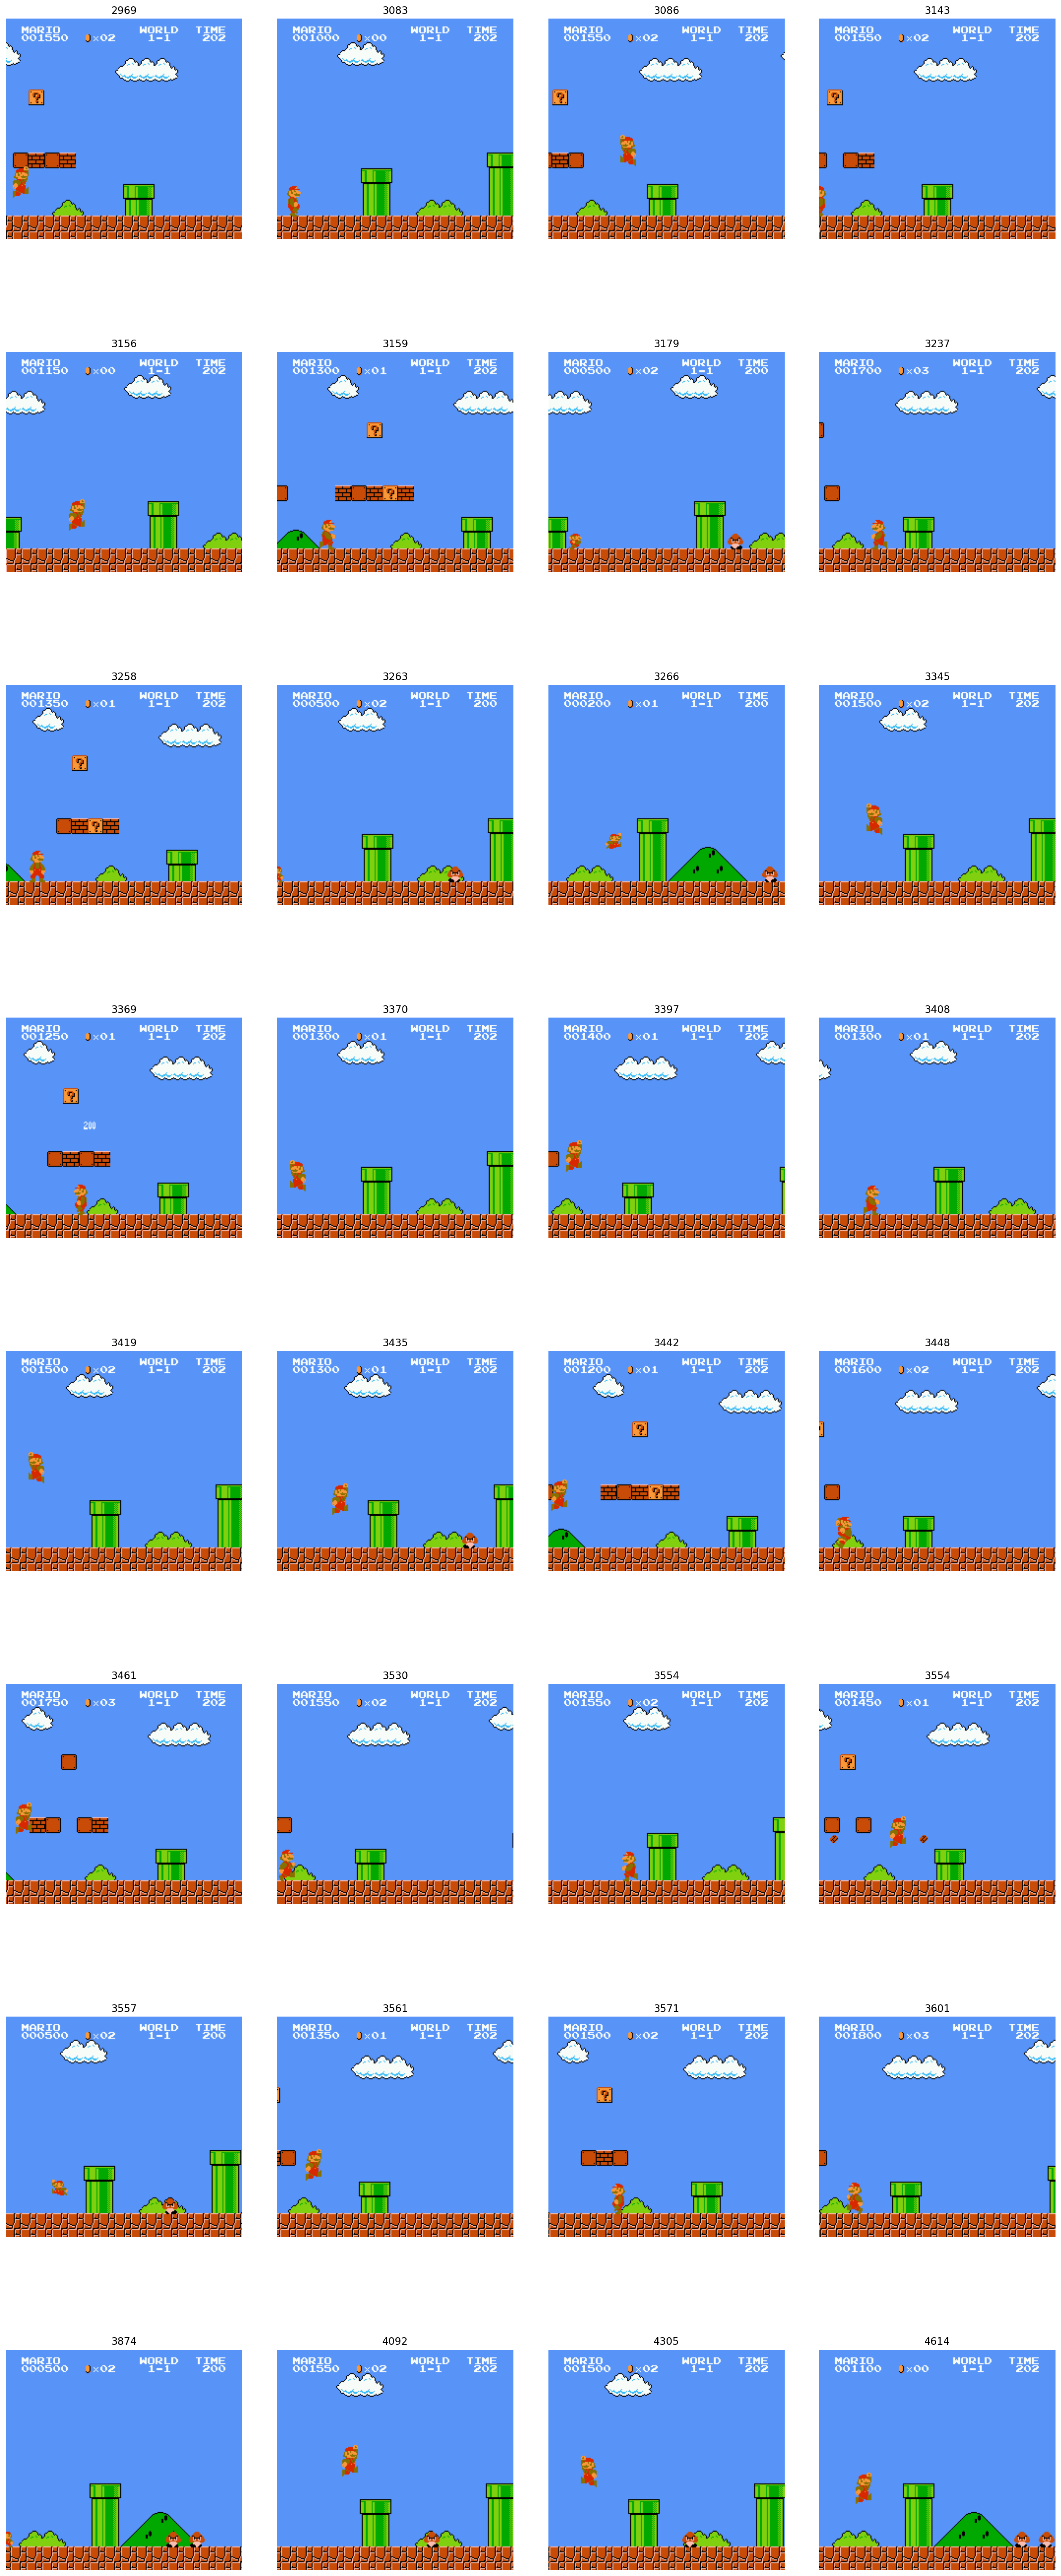

In [105]:
ls_frames = environments.sortByKey().collect()
# frames = sorted(frames, lambda x: x[0])

# frames

ls_frames = ls_frames[-32:]

fig, axs = plt.subplots(8, 4, figsize=(18, 44))
axs = axs.flatten()
fig.tight_layout()

for ax, (l, frame) in zip(axs, ls_frames):
    ax.imshow(frame)
    ax.axis('off')
    ax.set_title(l)

In [28]:
(frames[3] == frames[7]).sum()

161280

CPU times: user 2.17 s, sys: 499 ms, total: 2.67 s
Wall time: 43.6 s


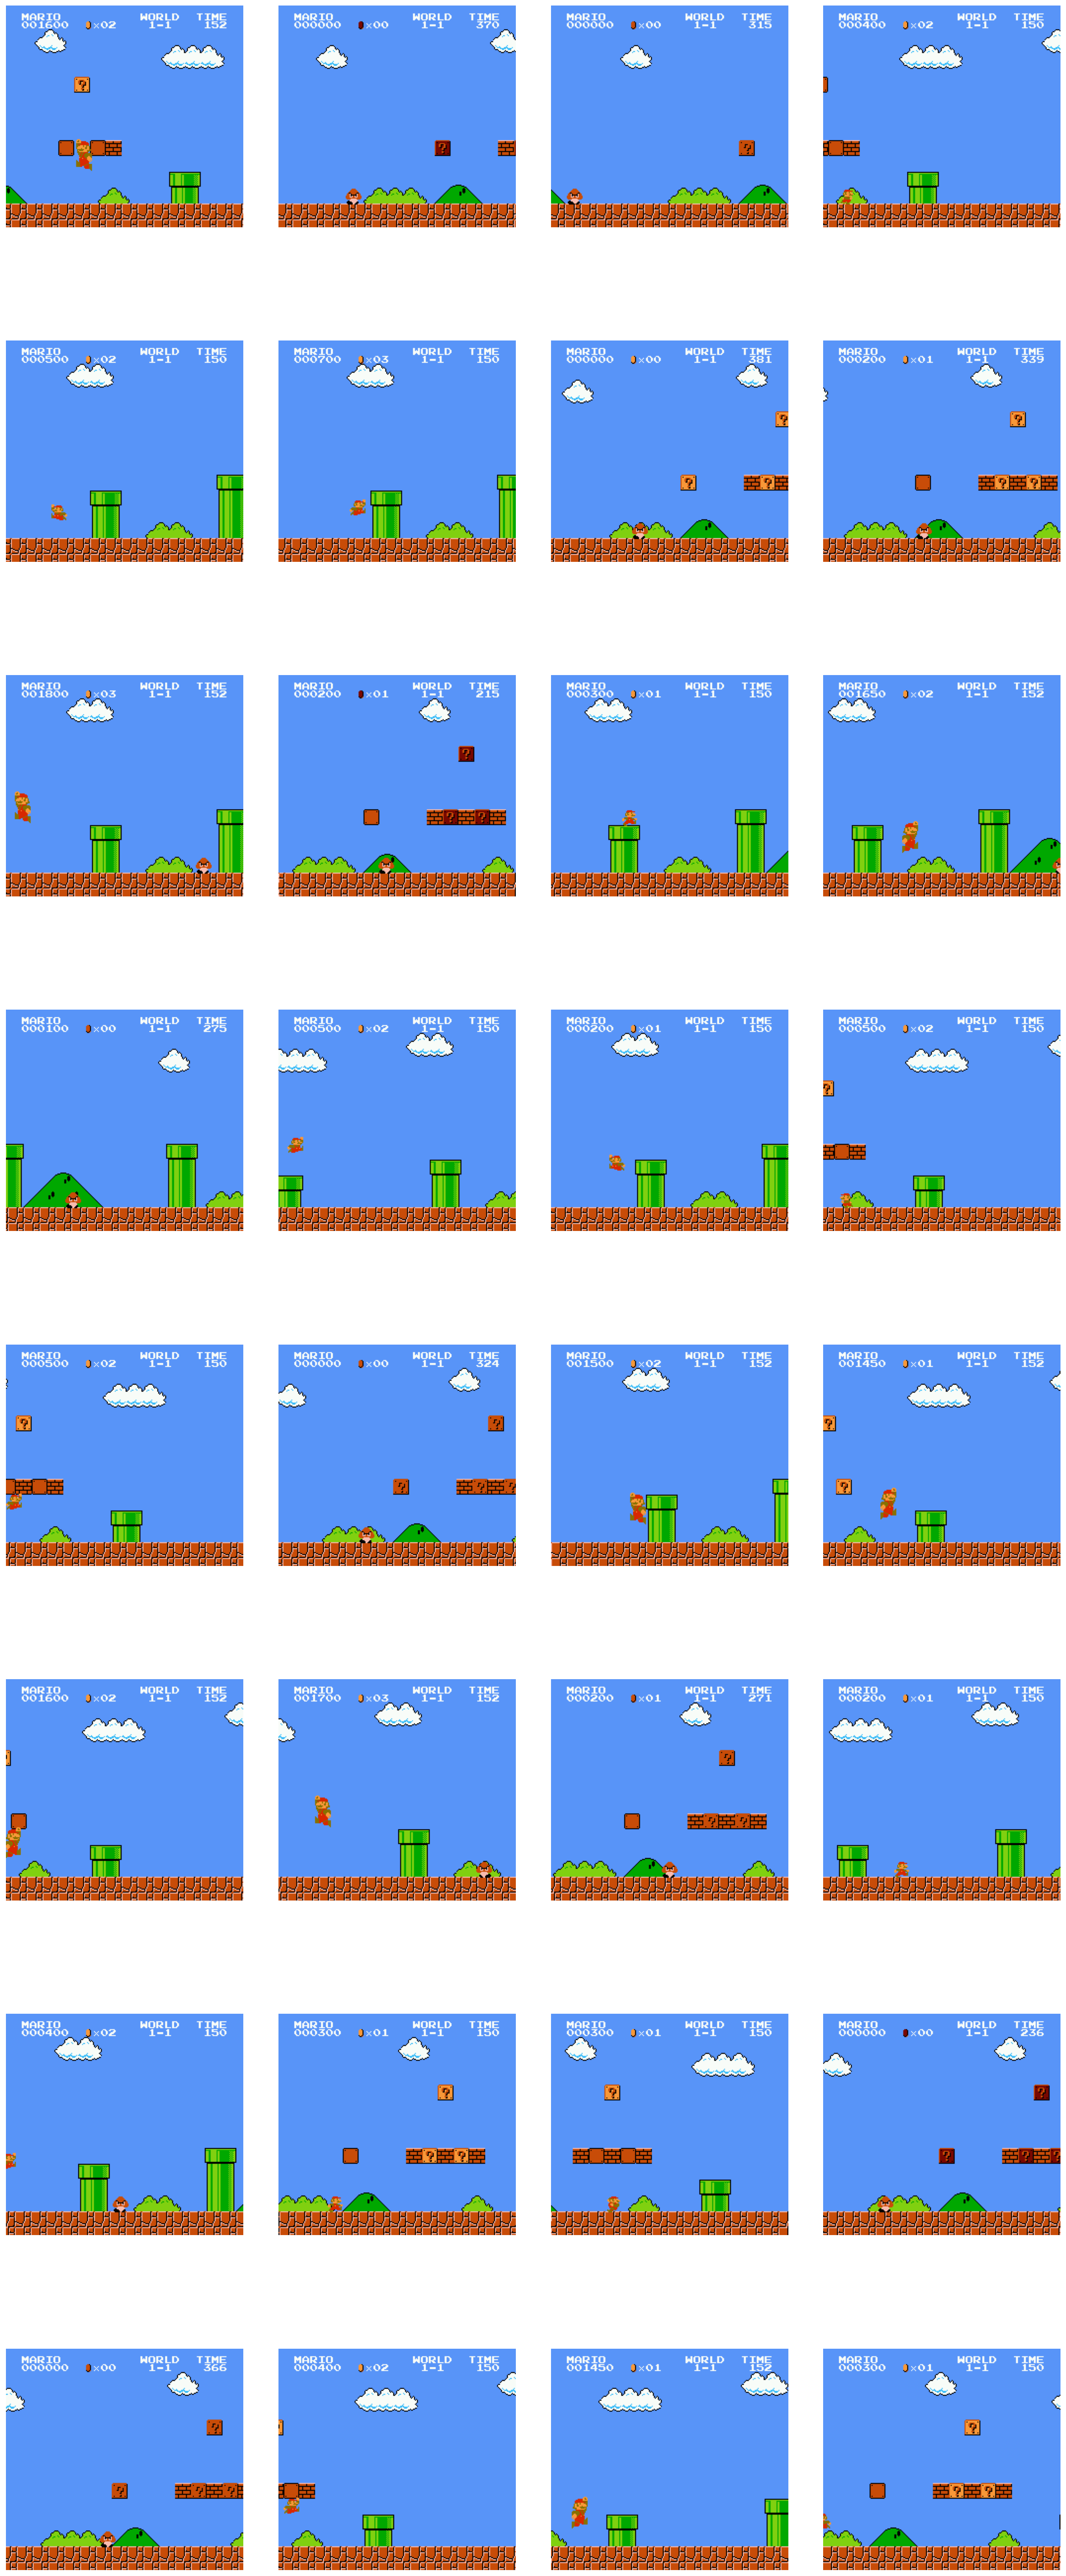

In [6]:
%%time

import matplotlib.pyplot as plt

environments = sc.parallelize(range(32)) .map (lambda x: generate_play(1000))
frames = environments.collect()

fig, axs = plt.subplots(8, 4, figsize=(18, 44))
axs = axs.flatten()
fig.tight_layout()

for ax, frame in zip(axs, frames):
    ax.imshow(frame)
    ax.axis('off')

In [ ]:
images = []
env.reset()

action = env.action_space.sample()

obs, rew, done, info = env.step(action)

In [ ]:
import json

def frame_draw(frame):
    height, width, colors = frame.shape
    frame_json = json.dumps(frame.tolist())
    
    return IPython.display.HTML("""
    <canvas id="myCanvas" width="%(width)s" height="%(height)s"></canvas>
    <script>
        c = document.getElementById("myCanvas");
        c.style.width = %(width)s*8/7 + 'px';
        c.style.height = %(width)s + 'px';
        
        var context = c.getContext("2d");
        context.scale(2, 2);
        
        frame = %(frame_json)s;
        height = frame.length;
        width = frame[0].length;

        for (var i = 0; i < width; i++) {
            for (var j = 0; j < height; j++) {
                context.beginPath();
                context.rect(i, j, 4, 4);
                context.fillStyle = 'rgb(' + frame[j][i].join(',') + ')';
                context.fill();
            }
        }
    </script>
    """ % {'frame_json': frame_json, 'width': 2*width, 'height': 2*height})
    
frame_draw(observation)

## ozx

In [ ]:
240 / 16, 224 / 16

In [ ]:
comps=[[0,1,3],[0,2,1],[0,2,3],[0,3,1],[0,3,2],[1,0,2],[1,0,3],[1,2,0],[1,2,3],[1,3,0],[1,3,2],[2,0,1],[2,0,3],[2,1,0],[2,1,3],[2,3,0],[2,3,1],[3,0,1],[3,0,2],[3,1,0],[3,1,2],[3,2,0],[3,2,1]]

torch.Size([14, 16, 16, 15, 3])
torch.Size([16, 15, 3])


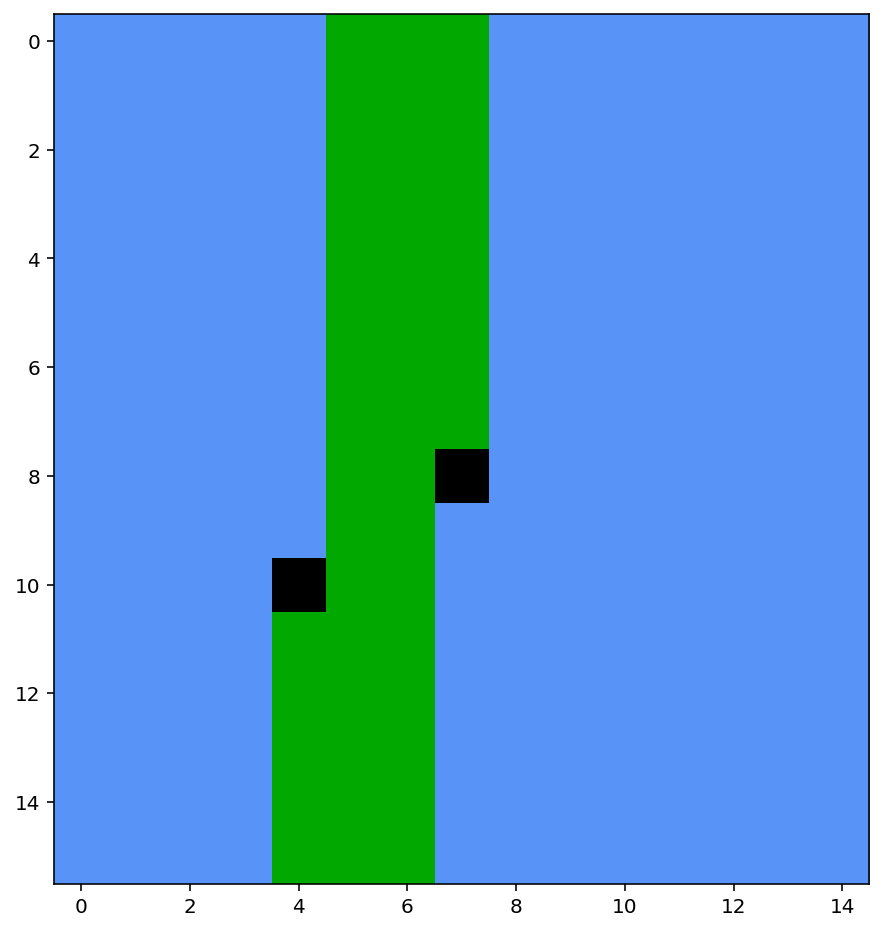

In [3]:
environment_make()
environment.reset()

action = environment.action_space.sample()

observation, rew, done, info = environment.step(action)

fig, ax = plt.subplots(figsize=(8, 8))

blocks = torch.tensor(observation).reshape(14, 15, 16, 16, 3).permute(0, 2, 3, 1, 4)
print(blocks.shape)
print(blocks[11][11].shape)
# print(blocks[11][11])
ax.imshow(blocks[11][11])


In [ ]:

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(torch.tensor(observation).reshape(-1, 224, 240, 3).permute(3, 1, 2, 0)[0]);
ax.axis('off');

In [ ]:
filters

In [ ]:
image

In [ ]:
filters = torch.randn(8,3,3,3)
inputs = torch.randn(1,3,1,2)
F.conv2d(image.float(), weight=filters, padding=1)

In [352]:
import torch.nn.functional as F

# image = torch.tensor(observation, dtype=float) #.reshape(-1, 3, 224, 240)
# print(image.shape)

t = torch.tensor(observation, dtype=float)
r, g, b = t[:,:,0], t[:,:,1], t[:,:,2]
image = torch.stack([r, g, b]).unsqueeze(0)
print("t", t.shape)


t = torch.tensor(observation, dtype=float).unsqueeze(0)
# r, g, b = t.permute(0, 3, 1, 2)
# image = torch.stack([r, g, b]).unsqueeze(0)
image = t.permute(0, 3, 1, 2)
print("t", t.shape)



filter_ = torch.tensor([[
    [[1, 1], [1, 1]],
    [[1, 1], [1, 1]],
    [[1, 1], [1, 1]]
]], dtype=float)

filter_ = filter_ / 4
filter_[0,0] = 0
filter_[0,1] = 0
filter_[0,2] = 1
print(filter_)
print(filter_.shape)
output = F.conv2d(input=image,
                  weight=filter_,
                  stride=2)

print("output:", output.shape)

fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(output.reshape(-1, 112, 120, 1)[0], cmap='gray')

NameError: name 'observation' is not defined

In [ ]:
224*240, 224*240/16/16/15

In [ ]:
torch.ones(4, 4)

In [ ]:
588*16*16,224*240

In [ ]:
def block_partition(matrix, block_width):
    total_width = matrix.shape[0]
    
    matrix = matrix.reshape(-1, block_width, total_width // block_width, block_width)
    matrix = matrix.transpose(2, 1).reshape(-1, block_width, block_width)
    
    return matrix

t = torch.tensor(observation)
r, g, b = t.permute(2, 0, 1)
t= t.permute(2, 0, 1)

print(r.shape)

r = block_partition(r[:224,:224], 16)
print(r.shape)

r = r[-40]
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(r);

In [ ]:

t = torch.tensor(observation) #.unsqueeze(0)
# r, g, b = t.permute(0, 3, 1, 2)[0]
print("t", t.shape)
print("r", r.shape)

r = t
r = r.reshape(14, 15, 16, 16, 3)
r = r.permute(0, 1, 3, 2, 4)
r = r[-4][-7]

print(r.shape)

fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(r)

In [ ]:
def block_partition(matrix, block_width):
    matrix = matrix.reshape(-1, block_width, matrix.shape[0] // block_width, block_width, 3)
    matrix = matrix.transpose(2, 1).reshape(-1, block_width, block_width, 3)
    
    return matrix

t = torch.tensor(observation)

print(t.shape)

t = block_partition(t[:224,:224], 16)
print(t.shape)

# t = t[-40]
r = t[-40]
print(r.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(r);

exponent = 1

# [hash(((block.float() / 255 / 16 / 16).sum()**exponent).item()) % 255 for block in t]

In [2]:
def block_partition(matrix, block_width):
    matrix = matrix.reshape(-1, block_width, matrix.shape[0] // block_width, block_width, 3)
    matrix = matrix.transpose(2, 1).reshape(-1, block_width, block_width, 3)
    
    return matrix

t = torch.tensor(observation)

print(t.shape)

t = block_partition(t[:224,:224], 16)
print(t.shape)

# t = t[-40]
r = t[-40]
print(r.shape)

fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(r);

exponent = 1

k = set([tuple(block.flatten().tolist()) for block in t])
# k = sorted(list(k))
blocks = [torch.tensor(block).reshape(16, 16, 3) for block in k]

print(len(set([hash(((block.float() / 255 / 16 / 16).sum()**exponent).item()) % 255 for block in t])))
print(len(blocks))
ax.imshow(blocks[-5])

NameError: name 'observation' is not defined

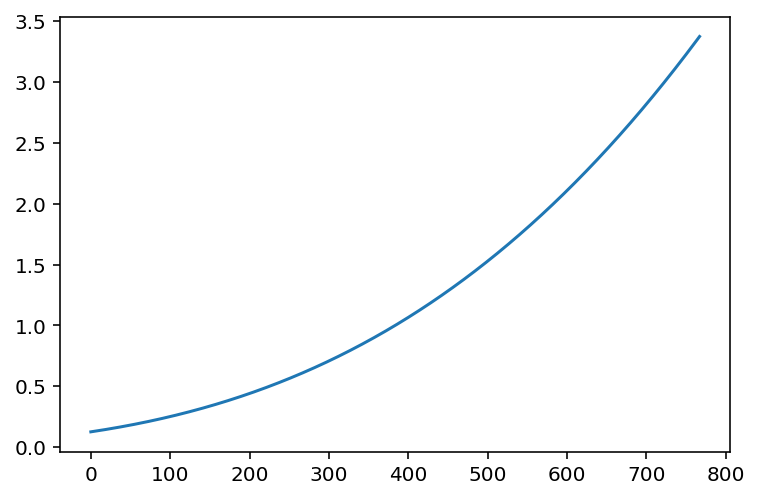

In [41]:
a1 = torch.linspace(0.5, 1.5, 16*16*3)**3

plt.plot(a1)

torch.Size([224, 240, 3])
torch.Size([196, 16, 16, 3])
torch.Size([16, 16, 3])
[0.7921485304832458, 0.9586583971977234, 0.9322603940963745, 0.8646268844604492, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.8901470899581909, 0.9529489874839783, 0.917827844619751, 0.7921485304832458, 0.8898940682411194, 0.9515265822410583, 0.7921485304832458, 0.8178447484970093, 0.8178447484970093, 0.8178447484970093, 0.7921485304832458, 0.782853901386261, 0.8178447484970093, 0.7921485304832458, 0.7921485304832458, 0.810614824295044, 0.8033480644226074, 0.7921485304832458, 0.8063144683837891, 0.8178447484970093, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.8417813777923584, 0.8400060534477234, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7921485304832458, 0.7

AttributeError: 'float' object has no attribute 'tolist'

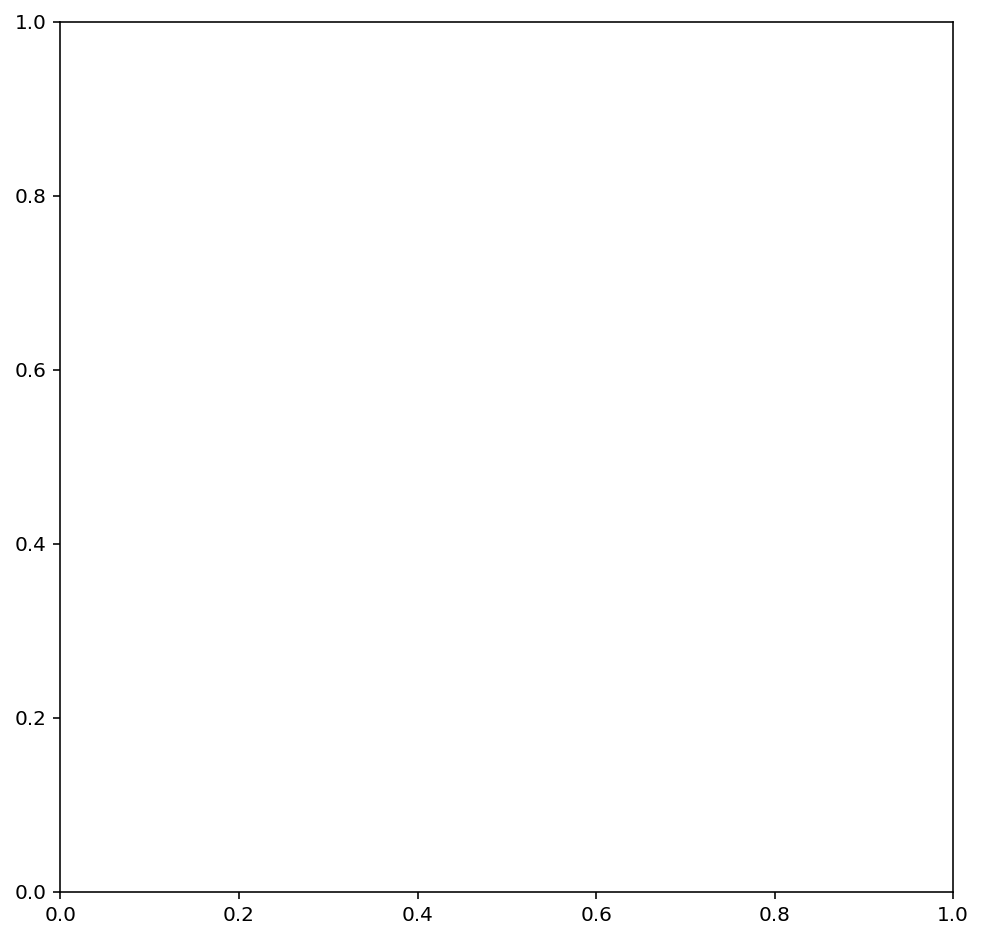

In [175]:
def block_partition(matrix, block_width):
    matrix = matrix.reshape(-1, block_width, matrix.shape[0] // block_width, block_width, 3)
    matrix = matrix.transpose(2, 1).reshape(-1, block_width, block_width, 3)
    
    return matrix

t = torch.tensor(observation)

print(t.shape)

t = block_partition(t[:224,:224], 16)
print(t.shape)

# t = t[-40]
r = t[-40]
print(r.shape)

fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(r);

exponent = 1

asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3

k = [((block.flatten().float() @ asymmetric / 16 / 16 / 3 / 255)).item() for block in t]
print(k)
k = set(tuple(block.tolist()) for block in k)
blocks = [torch.tensor(block).reshape(16, 16, 3) for block in k]

len(blocks)

In [64]:
t[0].flatten().float() @ asymmetric

tensor(155134.3750)

In [94]:
torch.chunk()

TypeError: chunk() missing 2 required positional argument: "input", "chunks"

In [90]:
torch.

['AVG',
 'AggregationType',
 'AnyType',
 'Argument',
 'ArgumentSpec',
 'BFloat16Storage',
 'BFloat16Tensor',
 'BenchmarkConfig',
 'BenchmarkExecutionStats',
 'Block',
 'BoolStorage',
 'BoolTensor',
 'BoolType',
 'BufferDict',
 'ByteStorage',
 'ByteTensor',
 'CONV_BN_FUSION',
 'CallStack',
 'Capsule',
 'CharStorage',
 'CharTensor',
 'ClassType',
 'Code',
 'CompilationUnit',
 'CompleteArgumentSpec',
 'ComplexDoubleStorage',
 'ComplexFloatStorage',
 'ConcreteModuleType',
 'ConcreteModuleTypeBuilder',
 'CudaBFloat16StorageBase',
 'CudaBoolStorageBase',
 'CudaByteStorageBase',
 'CudaCharStorageBase',
 'CudaComplexDoubleStorageBase',
 'CudaComplexFloatStorageBase',
 'CudaDoubleStorageBase',
 'CudaFloatStorageBase',
 'CudaHalfStorageBase',
 'CudaIntStorageBase',
 'CudaLongStorageBase',
 'CudaShortStorageBase',
 'DeepCopyMemoTable',
 'DeviceObjType',
 'DictType',
 'DoubleStorage',
 'DoubleTensor',
 'ErrorReport',
 'ExecutionPlan',
 'ExtraFilesMap',
 'FatalError',
 'FileCheck',
 'FloatStorage',

In [123]:
tensor.unsqueeze(0).shape

torch.Size([1, 224, 240, 3])

In [158]:
import torch.nn.functional as F

tensor = torch.tensor(observation)

print(tensor.shape)
tensor = tensor.unsqueeze(0)
print(tensor.shape)

unf1 = F.unfold(input=tensor.float(),
                kernel_size=(4, 4),
                stride=3)

plt.imshow(unf1[0])

torch.Size([224, 240, 3])
torch.Size([1, 224, 240, 3])


RuntimeError: Given input with spatial size (240, 240), kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), calculated shape of the array of sliding blocks as (79, 0), which is too small (non-positive).

torch.Size([240, 240, 3])
torch.Size([225, 16, 16, 3])
torch.Size([16, 16, 3])
35
36


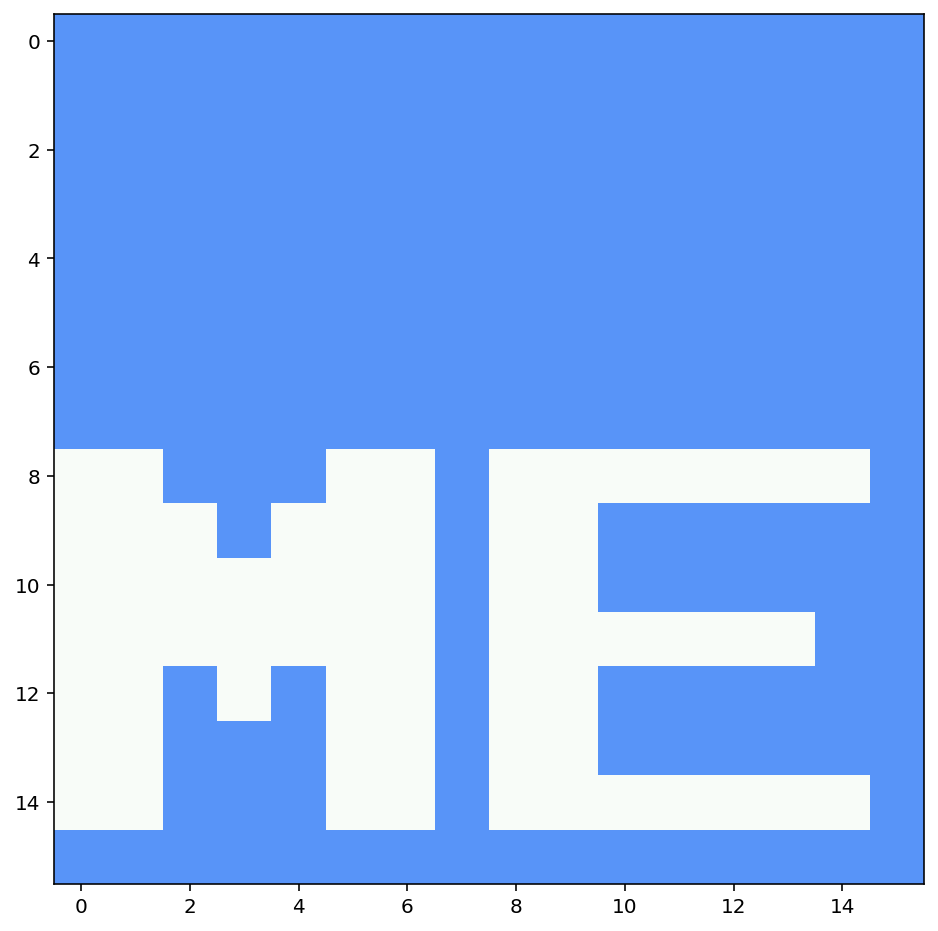

In [4]:
def block_partition(matrix, block_width):
    matrix = matrix.reshape(-1, block_width, matrix.shape[0] // block_width, block_width, 3)
    matrix = matrix.transpose(2, 1).reshape(-1, block_width, block_width, 3)
    
    return matrix

t = torch.tensor(observation)

t = torch.cat([
    torch.tensor(observation),
    torch.zeros(16, 240, 3)
]).long()

print(t.shape)

t = block_partition(t, 16)
print(t.shape)

r = t[-212]
print(r.shape)

fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(r);

exponent = 1

k = set([tuple(block.flatten().tolist()) for block in t])
# k = sorted(list(k))
blocks = [torch.tensor(block).reshape(16, 16, 3) for block in k]

print(len(set([hash(((block.float() / 255 / 16 / 16).sum()**exponent).item()) % 255 for block in t])))
print(len(blocks))
ax.imshow(r)

In [13]:
r;

In [12]:
PIL.Image.fromarray?

In [29]:
import PIL.Image

PIL.Image.fromarray(r.byte().numpy())

In [27]:
plt.imsave('/workfolder/toast.png', r.byte().numpy())

In [28]:
!open /workfolder/toast.png

/usr/bin/sh: 1: open: not found
